In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path

In [92]:
def compute_mvc_2d(src_pts, cage_pts, eps=1e-12, edge_atol=1e-9, fix_orientation=True):
    """
    2D Mean Value Coordinates for cage (Floater, 2003).
    
    Args:
        src_pts (np.ndarray): (V, 2) points inside the cage
        cage_pts (np.ndarray): (Nc, 2) cage vertices (counter-clockwise)
        eps (float): small number
        edge_atol (float): (alpha ~ pi)
        fix_orientation (bool): change orientation to CCW
    Returns:
        W (np.ndarray): (V, Nc) MVC weights (rows sum to 1)
    """
    src_pts  = np.asarray(src_pts,  dtype=np.float64)
    cage_pts = np.asarray(cage_pts, dtype=np.float64)
    V, Nc = src_pts.shape[0], cage_pts.shape[0]
    W = np.zeros((V, Nc), dtype=np.float64)

    if fix_orientation:
        area2 = np.sum(cage_pts[:,0]*np.roll(cage_pts[:,1], -1) -
                       cage_pts[:,1]*np.roll(cage_pts[:,0], -1))
        if area2 < 0:
            cage_pts = cage_pts[::-1].copy()

    idx_next = (np.arange(Nc) + 1) % Nc

    for vi in range(V):
        x = src_pts[vi]
        d = cage_pts - x                          # (Nc,2)
        r = np.linalg.norm(d, axis=1)             # (Nc,)
        j = np.argmin(r)

        if r[j] < eps:
            e = np.zeros(Nc); e[j] = 1.0
            W[vi] = e; continue

        u = d / (r[:,None] + eps)                 # (Nc,2)
        un = u[idx_next]                          # (Nc,2)

        cos = np.clip((u * un).sum(axis=1), -1.0, 1.0)  # ⟨u_i, u_{i+1}⟩
        sin = u[:,0]*un[:,1] - u[:,1]*un[:,0]           # cross2D(u_i, u_{i+1})_z

        on_edge = (np.abs(cos + 1.0) < edge_atol) & (np.abs(sin) < edge_atol)
        if np.any(on_edge):
            k = int(np.where(on_edge)[0][0])
            i0, i1 = k, idx_next[k]
            v0, v1 = cage_pts[i0], cage_pts[i1]
            seg = v1 - v0
            t = np.dot(x - v0, seg) / (np.dot(seg, seg) + eps)
            t = np.clip(t, 0.0, 1.0)
            e = np.zeros(Nc); e[i0] = 1.0 - t; e[i1] = t
            W[vi] = e; continue

        # tan(theta/2) = sin / (1+cos)
        denom = 1.0 + cos
        denom = np.where(np.abs(denom) < 1e-15, np.sign(denom)*1e-15, denom)
        tan_half = sin / denom                     # (Nc,)
        tan_prev = tan_half[np.arange(Nc) - 1]
        w = (tan_prev + tan_half) / (r + eps)      # (Nc,)

        s = w.sum()
        if np.abs(s) < eps:
            w[:] = 1.0 / Nc
        else:
            w /= s

        W[vi] = w

    return W



In [93]:
def forward_warp(img, dst_xy, out_size=None, mask=None, eps=1e-8):
    H, W, C = img.shape
    xy = dst_xy.reshape(-1, 2)
    if mask is None:
        m = np.ones((H, W), dtype=bool).reshape(-1)
    else:
        m = mask.reshape(-1).astype(bool)
    if out_size is None:
        xmin = np.floor(np.min(xy[m,0]))
        xmax = np.ceil (np.max(xy[m,0]))
        ymin = np.floor(np.min(xy[m,1]))
        ymax = np.ceil (np.max(xy[m,1]))
        H_out = max(int(ymax - ymin + 1), 1)
        W_out = max(int(xmax - xmin + 1), 1)
        xy = xy.copy()
        xy[:,0] -= xmin
        xy[:,1] -= ymin
    else:
        H_out, W_out = out_size
    out = np.zeros((H_out, W_out, C), dtype=np.float32)
    wsum = np.zeros((H_out, W_out), dtype=np.float32)
    colors = img.reshape(-1, C)
    x = xy[m, 0]; y = xy[m, 1]; col = colors[m]
    x0 = np.floor(x).astype(int); x1 = x0 + 1
    y0 = np.floor(y).astype(int); y1 = y0 + 1
    x0c = np.clip(x0, 0, W_out-1); x1c = np.clip(x1, 0, W_out-1)
    y0c = np.clip(y0, 0, H_out-1); y1c = np.clip(y1, 0, H_out-1)
    wa = (x1 - x) * (y1 - y)  # (x0,y0)
    wb = (x - x0) * (y1 - y)  # (x1,y0)
    wc = (x1 - x) * (y - y0)  # (x0,y1)
    wd = (x - x0) * (y - y0)  # (x1,y1)
    def add_at(img_accum, xs, ys, w, val):
        np.add.at(img_accum, (ys, xs), (w[:, None] * val))
    def add_at_w(waccum, xs, ys, w):
        np.add.at(waccum, (ys, xs), w)
    add_at(out, x0c, y0c, wa, col)
    add_at(out, x1c, y0c, wb, col)
    add_at(out, x0c, y1c, wc, col)
    add_at(out, x1c, y1c, wd, col)
    add_at_w(wsum, x0c, y0c, wa)
    add_at_w(wsum, x1c, y0c, wb)
    add_at_w(wsum, x0c, y1c, wc)
    add_at_w(wsum, x1c, y1c, wd)
    out = out / (wsum[..., None] + eps)
    return np.clip(out, 0, 1), wsum

def forward_warp_with_padding(img, dst_xy, out_size=None, mode='center', mask=None):
    H, W, _ = img.shape
    if out_size is None:
        H_out, W_out = H, W
    else:
        H_out, W_out = out_size
    if mask is None:
        m = np.ones((H, W), dtype=bool)
    else:
        m = mask.astype(bool)
    xy = dst_xy[m]
    if xy.size == 0:
        return np.zeros((H_out,W_out, img.shape[2]), dtype=img.dtype), np.zeros((H_out,W_out), dtype=np.float32), (0.0,0.0)
    xmin = float(np.floor(xy[:,0].min()))
    xmax = float(np.ceil (xy[:,0].max()))
    ymin = float(np.floor(xy[:,1].min()))
    ymax = float(np.ceil (xy[:,1].max()))
    bw = xmax - xmin + 1.0
    bh = ymax - ymin + 1.0
    if mode == 'center':
        tx = (W_out - bw) * 0.5 - xmin
        ty = (H_out - bh) * 0.5 - ymin
    else:
        tx = -xmin; ty = -ymin
    dst_shifted = dst_xy.copy()
    dst_shifted[...,0] = dst_xy[...,0] + tx
    dst_shifted[...,1] = dst_xy[...,1] + ty
    out, wsum = forward_warp(img, dst_shifted, out_size=(H_out, W_out), mask=mask)
    return out, wsum, (tx, ty)

def forward_warp_fixed_canvas(img, dst_xy, out_size=None, mask=None, eps=1e-8):
    H, W, C = img.shape
    
    if out_size is None:
        H_out, W_out = H, W
    else:
        H_out, W_out = out_size

    xy = dst_xy.reshape(-1, 2)
    colors = img.reshape(-1, C)

    if mask is None:
        m = np.ones((H*W,), dtype=bool)
    else:
        m = mask.reshape(-1).astype(bool)

    x = xy[m, 0]
    y = xy[m, 1]
    col = colors[m]

    x0 = np.floor(x).astype(int); x1 = x0 + 1
    y0 = np.floor(y).astype(int); y1 = y0 + 1

    wa = (x1 - x) * (y1 - y)  # (x0,y0)
    wb = (x - x0) * (y1 - y)  # (x1,y0)
    wc = (x1 - x) * (y - y0)  # (x0,y1)
    wd = (x - x0) * (y - y0)  # (x1,y1)

    out = np.zeros((H_out, W_out, C), dtype=np.float32)
    wsum = np.zeros((H_out, W_out), dtype=np.float32)

    def splat(neigh_x, neigh_y, w):
        valid = (neigh_x >= 0) & (neigh_x < W_out) & (neigh_y >= 0) & (neigh_y < H_out) & (w > 0)
        if not np.any(valid):
            return
        xs = neigh_x[valid]
        ys = neigh_y[valid]
        ww = w[valid][:, None]
        cc = col[valid]
        np.add.at(out, (ys, xs), ww * cc)
        np.add.at(wsum, (ys, xs), w[valid])

    splat(x0, y0, wa)
    splat(x1, y0, wb)
    splat(x0, y1, wc)
    splat(x1, y1, wd)

    out = out / (wsum[..., None] + eps)
    return np.clip(out, 0, 1), wsum


def box_blur(img, k=3):
    assert k % 2 == 1
    r = k // 2
    pad = np.pad(img, ((0,0),(r,r),(0,0)), mode='reflect')
    cumsum = np.cumsum(pad, axis=1)
    h = cumsum[:, 2*r+1:, :] - cumsum[:, :-2*r-1, :]
    h = h / float(k)
    pad = np.pad(h, ((r,r),(0,0),(0,0)), mode='reflect')
    cumsum = np.cumsum(pad, axis=0)
    v = cumsum[2*r+1:, :, :] - cumsum[:-2*r-1, :, :]
    v = v / float(k)
    return v

def downsample(x):
    return x[::2, ::2]

def upsample_bilinear(x, H, W):
    h, w, C = x.shape
    if h == H and w == W:
        return x.copy()
    ys = np.linspace(0, h-1, H)
    xs = np.linspace(0, w-1, W)
    yy, xx = np.meshgrid(ys, xs, indexing='ij')
    x0 = np.floor(xx).astype(int); x1 = np.clip(x0+1, 0, w-1)
    y0 = np.floor(yy).astype(int); y1 = np.clip(y0+1, 0, h-1)
    wx = (xx - x0)[..., None]; wy = (yy - y0)[..., None]  # (H,W,1)
    Ia = x[y0, x0]; Ib = x[y0, x1]; Ic = x[y1, x0]; Id = x[y1, x1]  # (H,W,C)
    out = (Ia*(1-wx)*(1-wy) + Ib*wx*(1-wy) + Ic*(1-wx)*wy + Id*wx*wy)
    return out

def inpaint_push_pull(img, wsum, levels=6, blur_k=5, eps=1e-8):
    H, W, C = img.shape
    w = wsum[..., None]
    iw = img * w
    iw_pyr = [iw.copy()]; w_pyr = [w.copy()]
    for _ in range(levels-1):
        iw_blur = box_blur(iw_pyr[-1], k=blur_k)
        w_blur  = box_blur(w_pyr[-1],  k=blur_k)
        iw_ds = downsample(iw_blur)
        w_ds  = downsample(w_blur)
        iw_pyr.append(iw_ds)
        w_pyr.append(w_ds)
        if iw_ds.shape[0] <= 1 or iw_ds.shape[1] <= 1:
            break
    acc = iw_pyr[-1]; wacc = w_pyr[-1]
    for lvl in range(len(iw_pyr)-2, -1, -1):
        ih = iw_pyr[lvl]; wh = w_pyr[lvl]
        acc_up  = upsample_bilinear(acc, ih.shape[0], ih.shape[1])
        wacc_up = upsample_bilinear(wacc, wh.shape[0], wh.shape[1])
        mask_hole = (wh <= eps).astype(acc_up.dtype)
        acc = ih + acc_up * mask_hole
        wacc = wh + wacc_up * mask_hole
    filled = acc / (wacc + eps)
    return np.clip(filled, 0, 1)

def forward_infill_warp_fixed_canvas(img, dst_xy, out_size=None, mask=None, levels=2, blur_k=5, eps=1e-8):
    H, W, C = img.shape
    
    if out_size is None:
        H_out, W_out = H, W
    else:
        H_out, W_out = out_size
        
    xy = dst_xy.reshape(-1, 2)
    colors = img.reshape(-1, C)
    if mask is None:
        m = np.ones((H*W,), dtype=bool)
    else:
        m = mask.reshape(-1).astype(bool)
    x = xy[m, 0]; y = xy[m, 1]; col = colors[m]
    x0 = np.floor(x).astype(int); x1 = x0 + 1
    y0 = np.floor(y).astype(int); y1 = y0 + 1
    wa = (x1 - x) * (y1 - y)
    wb = (x - x0) * (y1 - y)
    wc = (x1 - x) * (y - y0)
    wd = (x - x0) * (y - y0)
    out = np.zeros((H_out, W_out, C), dtype=np.float32)
    wsum = np.zeros((H_out, W_out), dtype=np.float32)
    def splat(nx, ny, w):
        valid = (nx >= 0) & (nx < W_out) & (ny >= 0) & (ny < H_out) & (w > 0)
        if not np.any(valid): return
        xs = nx[valid]; ys = ny[valid]; ww = w[valid][:, None]; cc = col[valid]
        np.add.at(out, (ys, xs), ww * cc); np.add.at(wsum, (ys, xs), w[valid])
    splat(x0, y0, wa); splat(x1, y0, wb); splat(x0, y1, wc); splat(x1, y1, wd)
    out = out / (wsum[..., None] + 1e-8)
    out = np.clip(out, 0, 1)
    out_filled = inpaint_push_pull(out, wsum, levels=levels, blur_k=blur_k)
    return out_filled, wsum

In [94]:
# Create cage 
theta = np.linspace(0, 2*np.pi, 6)[:-1] + 0.2
radius = np.array([1.0, 0.8, 1.3, 0.9, 1.0])

cage = np.stack([radius*np.cos(theta), radius*np.sin(theta)], axis=1)  # (5,2)
print(cage)


# Deform the cage (move vertices)
rng = np.random.default_rng(0)
deform = cage.copy()
# displacement = rng.normal(scale=0.25, size=deform.shape)
displacement = rng.normal(scale=0.5, size=deform.shape)
# print(displacement)
deform += displacement
print(deform)

[[ 0.98006658  0.19866933]
 [ 0.09112917  0.79479272]
 [-1.18256505  0.53994436]
 [-0.60850405 -0.66311599]
 [ 0.49180299 -0.87070651]]
[[ 1.04293169  0.1326169 ]
 [ 0.4113405   0.84724278]
 [-1.45039973  0.72074189]
 [ 0.04349597 -0.18957551]
 [ 0.13993537 -1.50341724]]


In [95]:
### just for visualization!!!!
# Generate a grid 

# src_cage = cage
# tgt_cage = deform
src_cage = deform
tgt_cage = cage

xmin, ymin = src_cage.min(axis=0) - 0.2
xmax, ymax = src_cage.max(axis=0) + 0.2
xx, yy = np.meshgrid(np.linspace(xmin, xmax, 50), np.linspace(ymin, ymax, 50))
grid = np.stack([xx.ravel(), yy.ravel()], axis=1)  # (M,2)

### pick points inside polygon
path = Path(src_cage)
mask_inside = path.contains_points(grid)

# interior points
# src = grid[mask_inside]
src = grid

In [96]:



# Compute MVC weights
# W = compute_mvc_2d(src, cage)
W = compute_mvc_2d(src, src_cage)
print(W.min(), W.max())
# print(W, W.min(), W.max())

# Map interior points using MVC
# dst = W @ deform  # (len(src), 2)
dst = W @ tgt_cage  # (len(src), 2)

-1.0474134889333122 2.3850159551839956


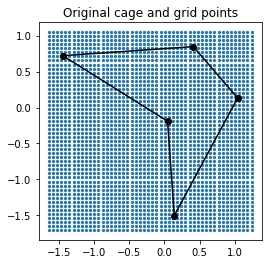

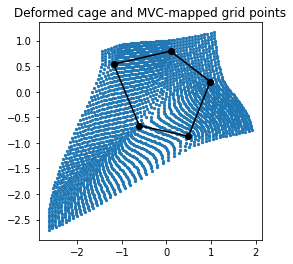

0.9999999999999994 1.0000000000000007 1.0


In [100]:



# 1) Original cage + interior samples
SIZE=4
plt.figure(figsize=(SIZE,SIZE))
plt.plot(*np.vstack([src_cage, src_cage[0]]).T, '-o', c='black')
plt.scatter(src[:,0], src[:,1], s=5)
plt.title("Original cage and grid points")
# plt.gca().set_aspect('equal', 'box')
plt.show()

# 2) Deformed cage + mapped points
plt.figure(figsize=(SIZE,SIZE))
plt.plot(*np.vstack([tgt_cage, tgt_cage[0]]).T, '-o', c='black')
plt.scatter(dst[:,0], dst[:,1], s=5)
plt.title("Deformed cage and MVC-mapped grid points")
# plt.gca().set_aspect('equal', 'box')
plt.show()

sum_rows = np.sum(W, axis=1)
print(np.min(sum_rows), np.max(sum_rows), np.mean(sum_rows))

In [325]:
def bilinear_sample(img, xy):
    H, W, C = img.shape
    x = xy[:,0]
    y = xy[:,1]
    x0 = np.floor(x).astype(int)
    y0 = np.floor(y).astype(int)
    x1 = x0 + 1
    y1 = y0 + 1
    x0 = np.clip(x0, 0, W-1)
    x1 = np.clip(x1, 0, W-1)
    y0 = np.clip(y0, 0, H-1)
    y1 = np.clip(y1, 0, H-1)
    Ia = img[y0, x0]
    Ib = img[y0, x1]
    Ic = img[y1, x0]
    Id = img[y1, x1]
    wa = (x1 - x) * (y1 - y)
    wb = (x - x0) * (y1 - y)
    wc = (x1 - x) * (y - y0)
    wd = (x - x0) * (y - y0)
    out = (Ia * wa[:,None] + Ib * wb[:,None] + Ic * wc[:,None] + Id * wd[:,None])
    return out

# Create procedural RGB image
H, W = 360, 480
yy, xx = np.meshgrid(np.linspace(0,1,H), np.linspace(0,1,W), indexing='ij')
img = np.zeros((H, W, 3), dtype=np.float32)
img[...,0] = xx
img[...,1] = yy
img[...,2] = (np.sin(6*np.pi*xx)*np.cos(4*np.pi*yy)+1) * 0.5
img[...,0] -= img[...,2] *0.5
img[...,1] -= img[...,2] *0.5
print(img.shape)


# Source cage (octagon)
pad = 35
src_cage = np.array([
    [pad, pad],
    [W/2, 0+pad],
    [W-pad, pad],
    [W-pad, H/2],
    [W-pad, H-pad],
    [W/2, H-pad],
    [pad, H-pad],
    [pad, H/2],
], dtype=np.float64)
src_cage = src_cage * 0.9 + 15
# src_cage = src_cage * 0.35 + pad*4

# Deformed cage
deform = src_cage.copy() #* 1.2 - 0.6
deform[1] += np.array([-80,  30])
deform[3] += np.array([-20, -10])
deform[5] += np.array([-60, -30])
deform[7] += np.array([ 30, -20])


deform2 = src_cage.copy() *0.8 + 0.4*35
deform2[0] += np.array([80,  30])
deform2[2] += np.array([-20, -10])
deform2[4] += np.array([60, -30])
deform2[6] += np.array([ 30, 20])

def z_rotation_2D(angle):
    angle = np.pi * angle / 180.0
    c, s = np.cos(angle), np.sin(angle)
    R = np.array([[   c,        -s,        0.0],
                  [   s,         c,        0.0],
                  [ 0.0,       0.0,        1.0],], dtype=np.float32)
    return R


(360, 480, 3)


In [377]:

_cage_h = np.concatenate([deform2, np.ones((src_cage.shape[0],1))], axis=-1)
deform3 = _cage_h @ z_rotation_2D(60)
deform3 = deform3[:,:2]
deform3 = deform3 - deform3.mean(0)[None] + src_cage.mean(0)[None]
deform3

array([[122.31017938, 213.95629227],
       [130.12941773, 140.41297603],
       [185.26916385,  24.90813649],
       [294.34246826,  64.78762873],
       [388.77475715,  50.02610543],
       [310.9555188 , 244.81297603],
       [269.47602656, 356.65756169],
       [146.74246826, 320.43832333]])

In [327]:
pad = 30
mesh_tgt = np.array([
    # x , y
    [pad, pad],
    [pad*2, pad],
    [pad*3, pad],
    [pad*4, pad],
    [pad*5, pad],
    [pad*6, pad],
    [pad*7, pad],
    [pad*8, pad],
    [pad*9, pad],
    
    [pad*9, pad*2],
    [pad*9, pad*3],
    [pad*9, pad*4],
    [pad*9, pad*5],
    [pad*9, pad*6],
    [pad*9, pad*7],
    
    [pad*8, pad*7],
    [pad*7, pad*7],
    [pad*6, pad*7],
    [pad*5, pad*7],
    [pad*4, pad*7],
    [pad*3, pad*7],
    [pad*2, pad*7],
    [pad*1, pad*7],
    
    [pad*1, pad*6],
    [pad*1, pad*5],
    [pad*1, pad*4],
    [pad*1, pad*3],
    [pad*1, pad*2],
    [pad*1, pad*1],
    
], dtype=np.float64)

mesh_tgt[:,0] += 70
mesh_tgt[:,1] += 60

In [329]:
## grid
X, Y = np.meshgrid(np.arange(W), np.arange(H))
grid = np.stack([X.ravel(), Y.ravel()], axis=1)
path = Path(deform)
inside = path.contains_points(grid)
pts_tgt = grid[inside]
pts_tgt_out = grid[~inside]


path_src = Path(src_cage)
inside_src = path_src.contains_points(grid)


path_def2 = Path(deform2)
inside_def2 = path_def2.contains_points(grid)

In [330]:
warped = np.zeros_like(img)


# ### grid inside cage
# # deformation
# W_mvc = compute_mvc_2d(pts_tgt, deform)
# pts_src = W_mvc @ src_cage

# # Backward mapping
# rgb = bilinear_sample(img, pts_src[:, [0,1]])

# ## HW flatten
# warped.reshape(-1,3)[inside] = rgb


# ### grid outside cage
# # deformation
# W_mvc_out = compute_mvc_2d(pts_tgt_out, deform)
# pts_src_out = W_mvc_out @ src_cage

# # Backward mapping
# rgb_out = bilinear_sample(img, pts_src_out[:, [0,1]])

# ## HW flatten
# warped.reshape(-1,3)[~inside] = rgb_out

W_grid = compute_mvc_2d(grid, src_cage)
print(W_grid.min(), W_grid.max())

grid_warped = W_grid @ deform
warped, wsum = forward_warp_fixed_canvas(img, grid_warped, out_size=None)

-0.14178386309625207 1.0630446629216577


In [378]:
warped2 = np.zeros_like(img)

# ### grid inside cage
# # deformation
# W_mvc2 = compute_mvc_2d(pts_tgt, deform2)
# pts_src2 = W_mvc2 @ src_cage

# # Backward mapping
# rgb2 = bilinear_sample(img, pts_src2[:, [0,1]])

# ## HW flatten
# warped2.reshape(-1,3)[inside] = rgb2


# ### grid outside cage
# # deformation
# W_mvc_out2 = compute_mvc_2d(pts_tgt_out, deform2)
# pts_src_out2 = W_mvc_out2 @ src_cage

# # Backward mapping
# rgb_out2 = bilinear_sample(img, pts_src_out2[:, [0,1]])

# ## HW flatten
# warped2.reshape(-1,3)[~inside] = rgb_out2


grid_warped2 = W_grid @ deform2
warped2, wsum = forward_warp_fixed_canvas(img, grid_warped2, out_size=None)

grid_warped3 = W_grid @ deform3
warped3, wsum = forward_warp_fixed_canvas(img, grid_warped3, out_size=None)

In [379]:
W_mvc_mesh_tgt = compute_mvc_2d(mesh_tgt, src_cage)
print(W_mvc_mesh_tgt.min(), W_mvc_mesh_tgt.max())

mesh_tgt_deform = W_mvc_mesh_tgt @ deform
mesh_tgt_deform2 = W_mvc_mesh_tgt @ deform2
mesh_tgt_deform3 = W_mvc_mesh_tgt @ deform3


0.01068991433319025 0.6293912298710119


In [380]:
cooord_bfr = img.copy()#[:,:,::-1]
cooord_bfr[:,:,2] = 0

cooord_aft = warped.copy()#[:,:,::-1]
cooord_aft[:,:,2] = 0

cooord_aft2 = warped2.copy()#[:,:,::-1]
cooord_aft2[:,:,2] = 0

cooord_aft3 = warped3.copy()#[:,:,::-1]
cooord_aft3[:,:,2] = 0

-0.14178386309625207 1.0630446629216577


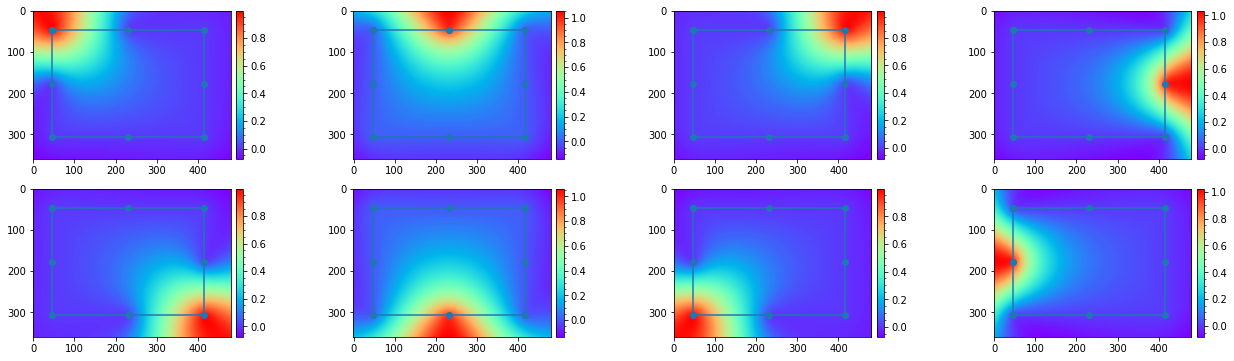

In [381]:

from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

cmap=plt.get_cmap("rainbow")

def show_gird_weight(img, src_cage, show_grid, col=2):
    fig1 = plt.figure(figsize=(22, 6))
    HW = show_grid.shape[-1]
    W = int(np.ceil(HW / col))
    for i in range(HW):
        plot_num = col*100+W*10+(i+1)
        ax1 = fig1.add_subplot(plot_num)
        im1 = ax1.imshow(show_grid[...,i].reshape(img.shape[0], img.shape[1], -1), cmap=cmap)
        ax1.plot(np.r_[src_cage[:,0], src_cage[0,0]], np.r_[src_cage[:,1], src_cage[0,1]], '-o')
        cbar = fig1.colorbar(im1, ax=ax1, fraction=0.035, pad=0.02)
        cbar.minorticks_on()
        
show_gird_weight(img, src_cage, W_grid, col=2)
print(W_grid.min(), W_grid.max())

# norm = Normalize(vmin=W_grid[...,7].min(), vmax=W_grid[...,7].max())
# mappable = ScalarMappable(norm=norm, cmap=cmap)
# mappable.set_array([])
# cbar = fig1.colorbar(mappable, ax=ax1, fraction=0.035, pad=0.02)
# cbar.set_label("range")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


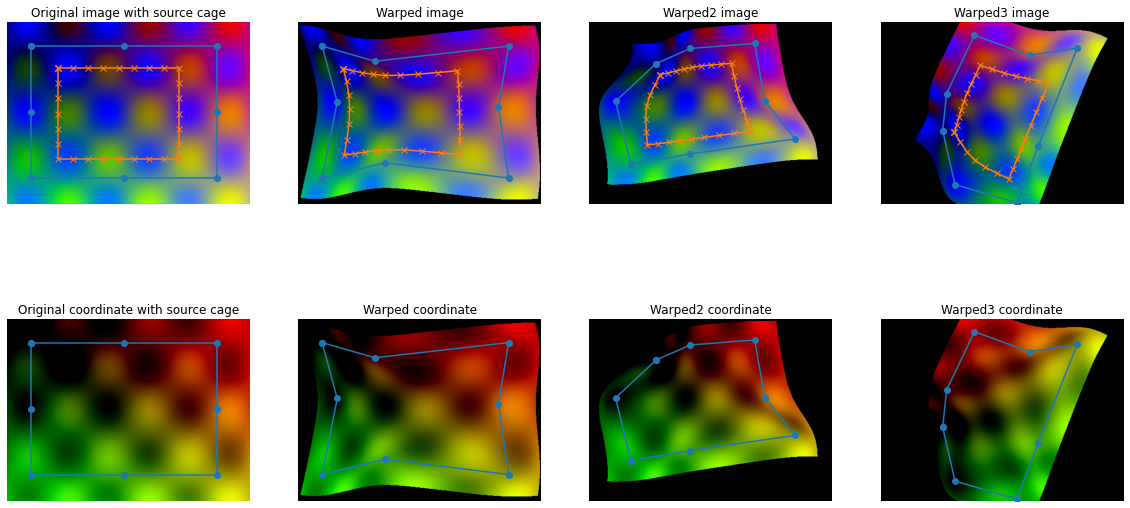

In [382]:

fig1 = plt.figure(figsize=(20, 10))

# Visualize
ax1 = fig1.add_subplot(241)

ax1.imshow(img)
ax1.plot(np.r_[src_cage[:,0], src_cage[0,0]], np.r_[src_cage[:,1], src_cage[0,1]], '-o')
ax1.plot(np.r_[mesh_tgt[:,0], mesh_tgt[0,0]], np.r_[mesh_tgt[:,1], mesh_tgt[0,1]], '-x')
ax1.set_title("Original image with source cage")
ax1.axis('off')

ax2 = fig1.add_subplot(242)
ax2.imshow(warped)
ax2.plot(np.r_[deform[:,0], deform[0,0]], np.r_[deform[:,1], deform[0,1]], '-o')
ax2.plot(np.r_[mesh_tgt_deform[:,0], mesh_tgt_deform[0,0]], np.r_[mesh_tgt_deform[:,1], mesh_tgt_deform[0,1]], '-x')
ax2.set_title("Warped image")
ax2.axis('off')


ax2 = fig1.add_subplot(243)
ax2.imshow(warped2)
ax2.plot(np.r_[deform2[:,0], deform2[0,0]], np.r_[deform2[:,1], deform2[0,1]], '-o')
ax2.plot(np.r_[mesh_tgt_deform2[:,0], mesh_tgt_deform2[0,0]], np.r_[mesh_tgt_deform2[:,1], mesh_tgt_deform2[0,1]], '-x')
ax2.set_title("Warped2 image")
ax2.axis('off')

ax2 = fig1.add_subplot(244)
ax2.imshow(warped3)
ax2.plot(np.r_[deform3[:,0], deform3[0,0]], np.r_[deform3[:,1], deform3[0,1]], '-o')
ax2.plot(np.r_[mesh_tgt_deform3[:,0], mesh_tgt_deform3[0,0]], np.r_[mesh_tgt_deform3[:,1], mesh_tgt_deform3[0,1]], '-x')
ax2.set_title("Warped3 image")
ax2.axis('off')



ax3 = fig1.add_subplot(245)
ax3.imshow(cooord_bfr)
ax3.plot(np.r_[src_cage[:,0], src_cage[0,0]], np.r_[src_cage[:,1], src_cage[0,1]], '-o')
ax3.set_title("Original coordinate with source cage")
ax3.axis('off')

ax4 = fig1.add_subplot(246)
ax4.imshow(cooord_aft)
ax4.plot(np.r_[deform[:,0], deform[0,0]], np.r_[deform[:,1], deform[0,1]], '-o')
ax4.set_title("Warped coordinate")
ax4.axis('off')


ax6 = fig1.add_subplot(247)
ax6.imshow(cooord_aft2)
ax6.plot(np.r_[deform2[:,0], deform2[0,0]], np.r_[deform2[:,1], deform2[0,1]], '-o')
ax6.set_title("Warped2 coordinate")
ax6.axis('off')

ax6 = fig1.add_subplot(248)
ax6.imshow(cooord_aft3)
ax6.plot(np.r_[deform3[:,0], deform3[0,0]], np.r_[deform3[:,1], deform3[0,1]], '-o')
ax6.set_title("Warped3 coordinate")
ax6.axis('off')

plt.show()
